In [1]:
# Helpers
import numpy as np
import pandas as pd
import pickle
import base64

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import analyzer
from tokenizer import create_bag_of_words
from coherence import calculate_uci_coherence

# Plots
import matplotlib.pyplot as plt
#import seaborn as sns

#DB
import psycopg2

# Learning
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

## Data

In [2]:
## Cleaning database
last_id = 132
# problems = Problem.objects.filter(id__gt=last_id)
# # solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
# print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be used: 132
Solutions to be used: 54
Got 54 documents


### Average terms/document

In [3]:
def get_avg_terms(ngrams):
    print(ng)
    analyzer.vectorizer_params = {'ngram_range': ngrams}
    vectorizer = CountVectorizer(analyzer=analyzer.python_analyzer)
    train_data_features = vectorizer.fit_transform(solutions)
    tokens = np.asarray(train_data_features.sum(axis=1)).reshape(-1)
    total = tokens.sum()
    vocab = train_data_features.shape[1]
    summary = {"max": tokens.max(),
               "argmax": tokens.argmax(),
               "min": tokens.min(),
               "argmin": tokens.argmin(),
               "avg": tokens.mean(),
               "total": total,
               "vocab": vocab,
               "sparsity": 100 * total / (vocab * train_data_features.shape[0])}
    plt.figure()
    n, bins, patches = plt.hist(tokens, alpha=0.7)
    plt.show()
    return summary

def get_avg_regular_terms(ngrams):
    print(ng)
    analyzer.vectorizer_params = {'ngram_range': ngrams}
    vectorizer = CountVectorizer()
    train_data_features = vectorizer.fit_transform(solutions)
    tokens = np.asarray(train_data_features.sum(axis=1)).reshape(-1)
    total = tokens.sum()
    vocab = train_data_features.shape[1]
    summary = {"max": tokens.max(),
               "argmax": tokens.argmax(),
               "min": tokens.min(),
               "argmin": tokens.argmin(),
               "avg": tokens.mean(),
               "total": total,
               "vocab": vocab,
               "sparsity": 100 * total / (vocab * train_data_features.shape[0])}
    plt.figure()
    n, bins, patches = plt.hist(tokens, alpha=0.7)
    plt.show()
    return summary

(1, 1)


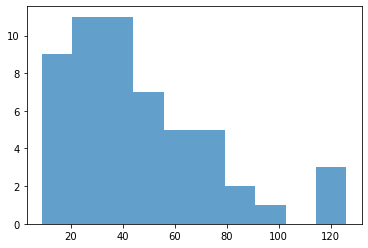

(1, 2)


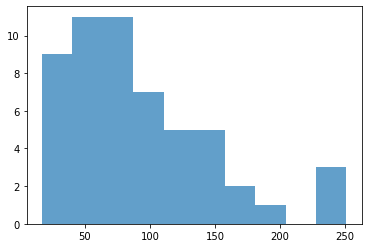

(1, 3)


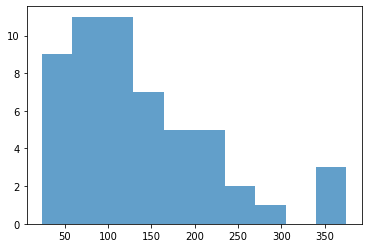

(2, 2)


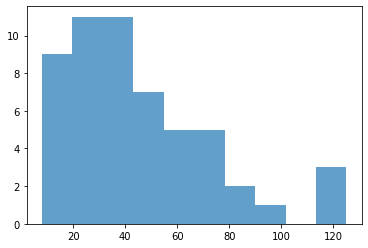

(2, 3)


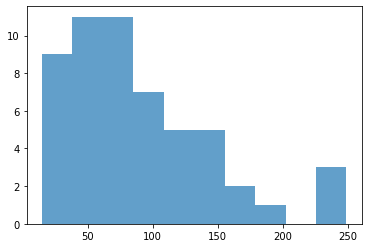

(3, 3)


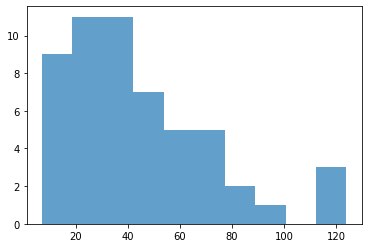

(1, 1)


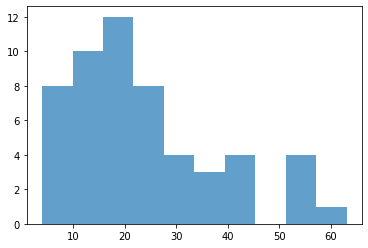

(1, 2)


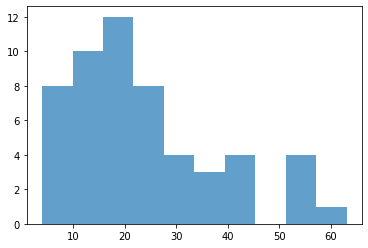

(1, 3)


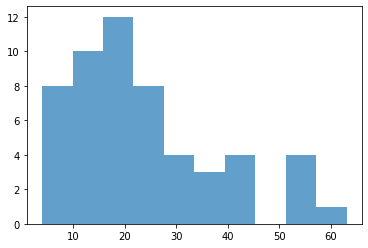

(2, 2)


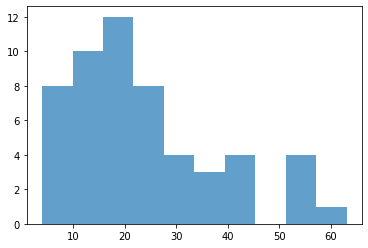

(2, 3)


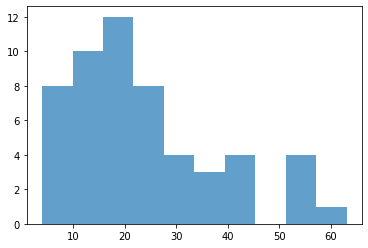

(3, 3)


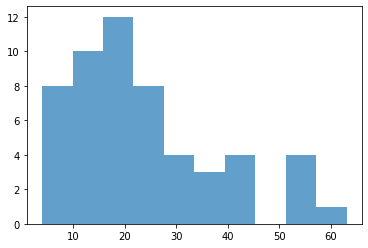

In [6]:
ngrams = [
    (1,1), # unigrams
    (1,2), # unigrams + bigrams
    (1,3), # unigrams + bigrams + trigrams
    (2,2), # bigrams
    (2,3), # bigrams + trigrams
    (3,3), # trigrams
]
summary = {}

for ng in ngrams:
    summary[ng] = get_avg_terms(ng)
    
for ng in ngrams:
    summary["regular_%s_%s" % ng] = get_avg_regular_terms(ng)

In [7]:
summary

{(1, 1): {'max': 126,
  'argmax': 30,
  'min': 9,
  'argmin': 4,
  'avg': 46.77777777777778,
  'total': 2526,
  'vocab': 215,
  'sparsity': 21.757105943152453},
 (1, 2): {'max': 251,
  'argmax': 30,
  'min': 17,
  'argmin': 4,
  'avg': 92.55555555555556,
  'total': 4998,
  'vocab': 1112,
  'sparsity': 8.323341326938449},
 (1, 3): {'max': 375,
  'argmax': 30,
  'min': 24,
  'argmin': 4,
  'avg': 137.33333333333334,
  'total': 7416,
  'vocab': 2388,
  'sparsity': 5.750977107761027},
 (2, 2): {'max': 125,
  'argmax': 30,
  'min': 8,
  'argmin': 4,
  'avg': 45.77777777777778,
  'total': 2472,
  'vocab': 897,
  'sparsity': 5.103431190387712},
 (2, 3): {'max': 249,
  'argmax': 30,
  'min': 15,
  'argmin': 4,
  'avg': 90.55555555555556,
  'total': 4890,
  'vocab': 2173,
  'sparsity': 4.1673058240016365},
 (3, 3): {'max': 124,
  'argmax': 30,
  'min': 7,
  'argmin': 4,
  'avg': 44.77777777777778,
  'total': 2418,
  'vocab': 1276,
  'sparsity': 3.5092302333681644},
 'regular_1_1': {'max': 63,
 

min lines: 2
max lines: 26
median lines: 8
avg lines: 9


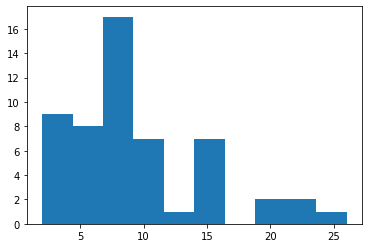

In [9]:
linebreaks = []
for sol in solutions:
    linebreaks.append(sol.count('\n')+1)
linebreaks = np.asarray(linebreaks)
print('min lines: %d' % linebreaks.min())
print('max lines: %d' % linebreaks.max())
print('median lines: %d' % np.median(linebreaks))
print('avg lines: %d' % np.mean(linebreaks))

#a = plt.boxplot(linebreaks)
a = plt.hist(linebreaks)
plt.show()

## Calculate PMI/UCI Coherence

In [10]:
%%time 
# Insert to DB
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                          password = settings.DATABASES["default"]["PASSWORD"],
                          host = settings.DATABASES["default"]["HOST"],
                          port = settings.DATABASES["default"]["PORT"],
                          database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

CPU times: user 3.6 ms, sys: 0 ns, total: 3.6 ms
Wall time: 91.3 ms


### Comparing paper reported result with top-15 coherence reruns

| Experiment ID | Min DF | Binary | Vectorizer | Method | Best k | NGrams | Table|
|---------------|--------|--------|------------|--------|--------|--------|------|
| 26            | 0.05   | True   | Count      | LDA    | 12     | 1 - 3  | experiments_solution (original)
| 79            | 0.05   | True   | Count      | NMF    | 13     | 1 - 3  | experiments_2020_01_27 (overall best)
| 78030         | 0.05   | True   | Count      | LDA    | 12     | 1 - 3  | experiments_2020_01_27 (closest in coherence) 
| 29310         | 0.05   | True   | Count      | LDA    | 12     | 1 - 3  | experiments_2020_01_27 (best in same configuration)

In [11]:
def get_where_items(exp_id, cols, table):
    query = "SELECT %s from %s where experiment_id = %s" % (", ".join(cols), table, exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def assign_to_cluster(exp_id, cols, table, solutions, exercise_sol):
    where_items = get_where_items(exp_id, cols, table)
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    if len(where_items[0]) == 5:
        ng = where_items[0][4]
        vectorizer_params={'ngram_range': ng}
    else:
        vectorizer_params={'ngram_range': (1,3)}
    model_db = pickle.loads(base64.b64decode(where_items[0][3]))
    _, vectorizer, _ = create_bag_of_words(solutions, v, binary=b, min_df=m, vectorizer_params=vectorizer_params)
    train_data_features = vectorizer.transform(exercise_sol)
    document_topic = model_db.transform(train_data_features)
    document_clusters = document_topic.argmax(axis=1)
    return vectorizer, document_clusters, train_data_features.toarray()

def get_cluster_sets(clusters1, clusters2):
    heatmap = np.zeros((clusters1.shape[0], clusters2.shape[0]))
    idx_sorted = np.argsort(clusters1)
    c1_old = 0
    c2_clusters = []
    fig, ax = plt.subplots(figsize=(18,18))
    for i, idx  in enumerate(idx_sorted):
        # Get element cluster
        c1 = clusters1[idx]
        # Get in which cluster from clusters 2 the same element is
        c2_ref = clusters2[idx]
        c2_clusters.append(c2_ref)
        for j, jdx in enumerate(idx_sorted):
            # Now, compare to another element in cluster 2
            c2 = clusters2[jdx]
            if c2 == c2_ref:
                heatmap[i,j] += 1
        if c1 != c1_old:
            plt.axhline(y=i-0.5, color='r', linestyle='-')
        c1_old = c1
    print(c2_clusters)
    im = ax.imshow(heatmap)
    ax.set_xticks(range(idx_sorted.shape[0]))
    ax.set_xticklabels(idx_sorted)
    ax.set_yticks(range(idx_sorted.shape[0]))
    ax.set_yticklabels(idx_sorted)
    fig.tight_layout()
    plt.show()
    return heatmap  

('CountVectorizer', 0.05, True, <memory at 0x7f462bff4d08>)


/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.online_lda module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


('CountVectorizer', 0.05, True, <memory at 0x7f462aca7348>, [1, 3])
[11, 9, 3, 12, 3, 3, 11, 0, 0, 12, 11, 0, 0, 0, 11, 0, 0, 0, 0, 0, 1, 5, 9, 1, 5, 5, 1, 6, 5, 5, 5, 1, 6, 6, 1, 4, 2, 2, 4, 4, 4, 4, 11, 3, 10, 10, 7, 8, 8, 8, 8, 9, 7, 7]


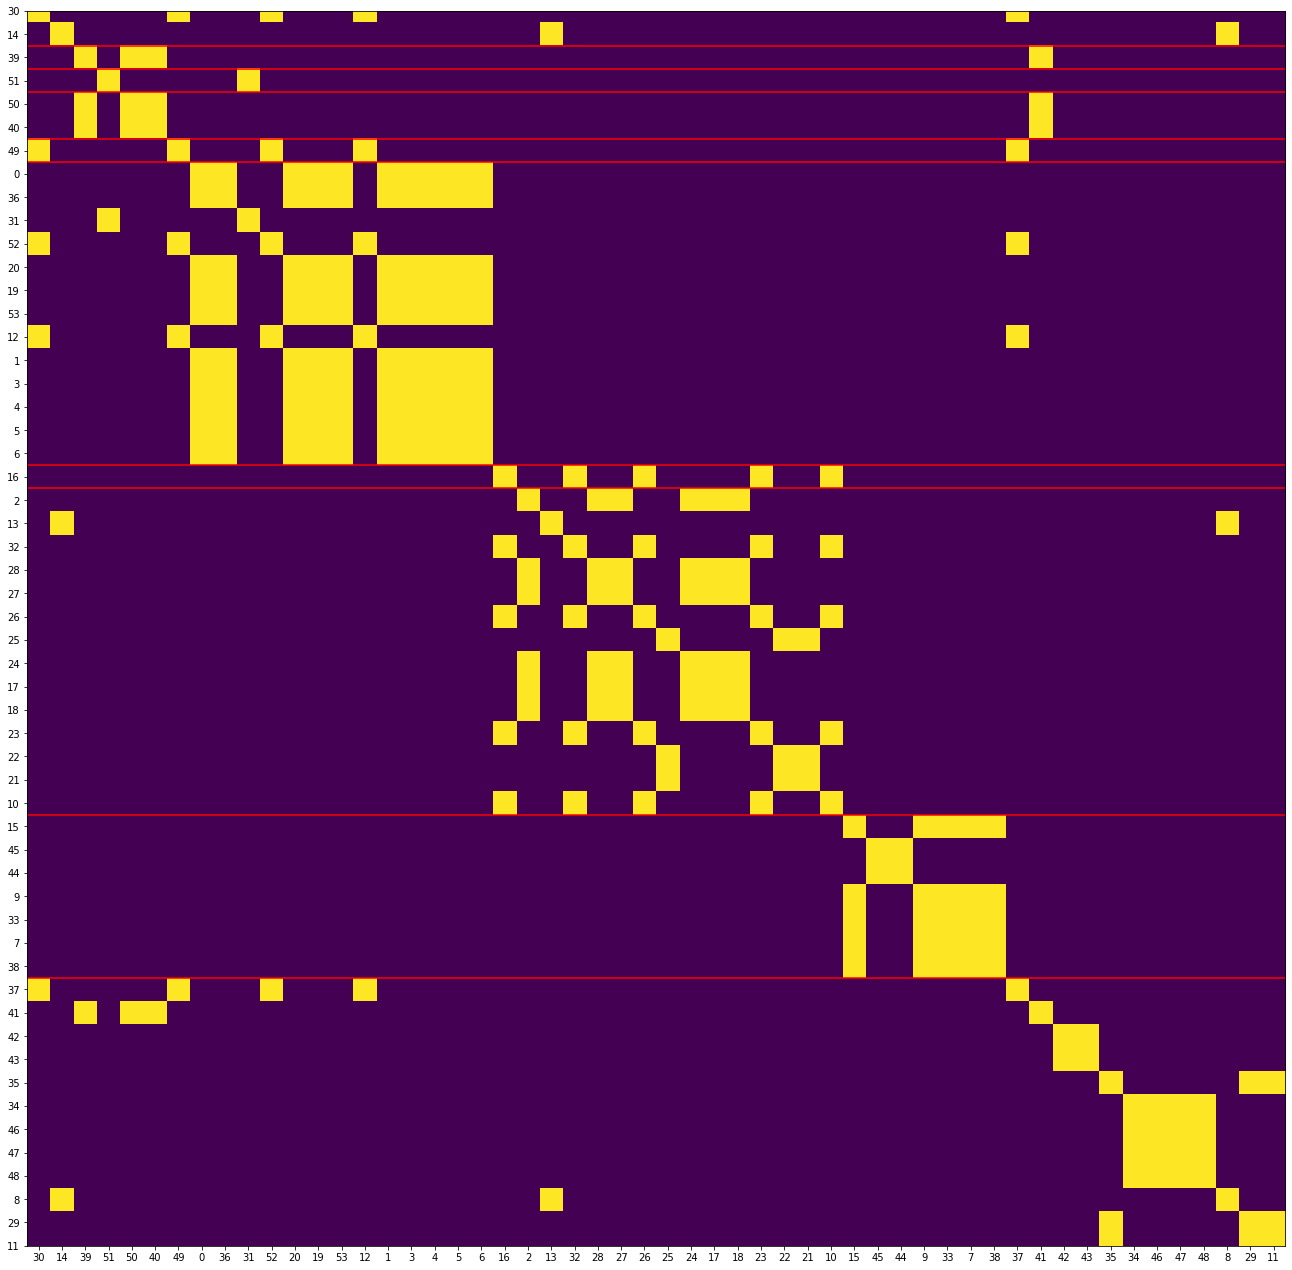

282.0

In [9]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "model"]
table = "experiments_solution"
print(get_where_items(exp_id, cols, table)[0])
_, clusters1, train_data_features = assign_to_cluster(exp_id, cols, table, solutions, solutions)

exp_id = 79
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
get_where_items(exp_id, cols, table)
print(get_where_items(exp_id, cols, table)[0])
_, clusters2, _ = assign_to_cluster(exp_id, cols, table, solutions, solutions)

heatmap = get_cluster_sets(clusters1, clusters2)
heatmap.sum()

('CountVectorizer', 0.05, True, <memory at 0x7f462bff4d08>)


/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


('CountVectorizer', 0.05, True, <memory at 0x7f462aca7348>, [1, 3])
[9, 4, 9, 6, 9, 9, 3, 9, 9, 10, 9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 2, 4, 4, 4, 4, 4, 0, 8, 4, 4, 4, 0, 8, 4, 0, 1, 6, 6, 1, 1, 1, 1, 10, 9, 1, 9, 11, 11, 9, 11, 11, 1, 4, 11]


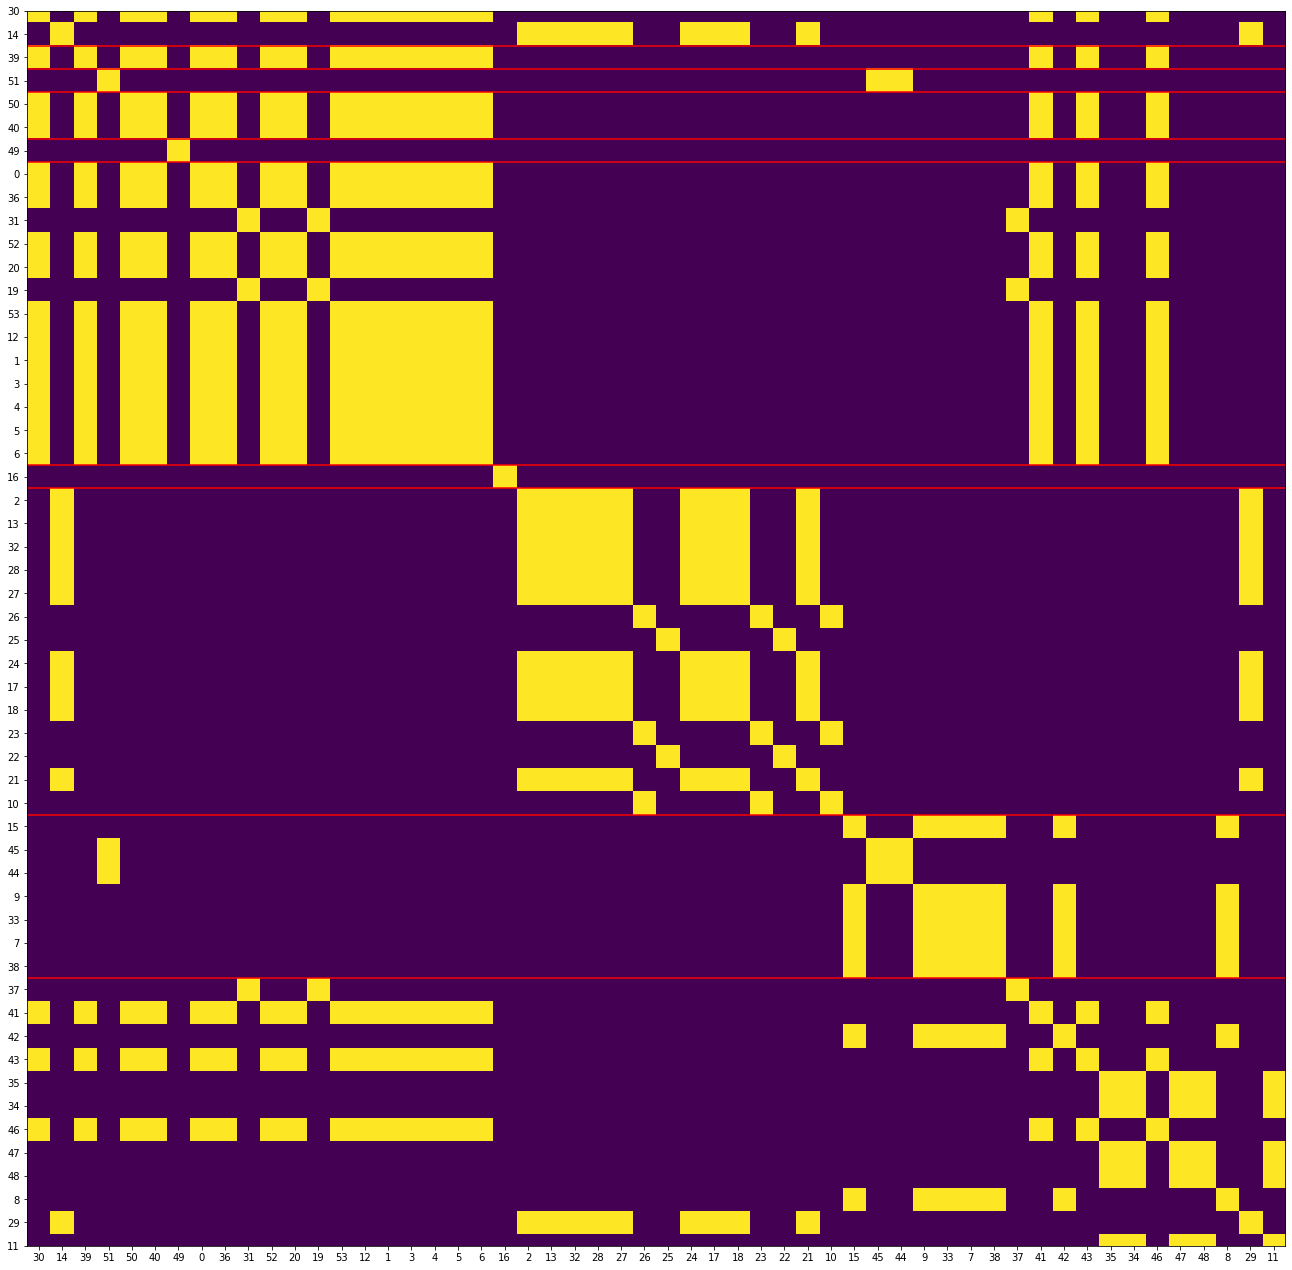

552.0

In [10]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "model"]
table = "experiments_solution"
print(get_where_items(exp_id, cols, table)[0])
_, clusters1, _ = assign_to_cluster(exp_id, cols, table, solutions, solutions)

exp_id = 78030
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
get_where_items(exp_id, cols, table)
print(get_where_items(exp_id, cols, table)[0])
_, clusters2, _ = assign_to_cluster(exp_id, cols, table, solutions, solutions)

heatmap = get_cluster_sets(clusters1, clusters2)
heatmap.sum()

('CountVectorizer', 0.05, True, <memory at 0x7f462bff4d08>)
('CountVectorizer', 0.05, True, <memory at 0x7f462aca7348>, [1, 3])
[10, 5, 5, 10, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 3, 3, 3, 4, 3, 3, 11, 11, 4, 11, 3, 11, 11, 3, 8, 0, 0, 8, 8, 5, 8, 10, 5, 5, 5, 1, 1, 10, 9, 10, 5, 1, 1]


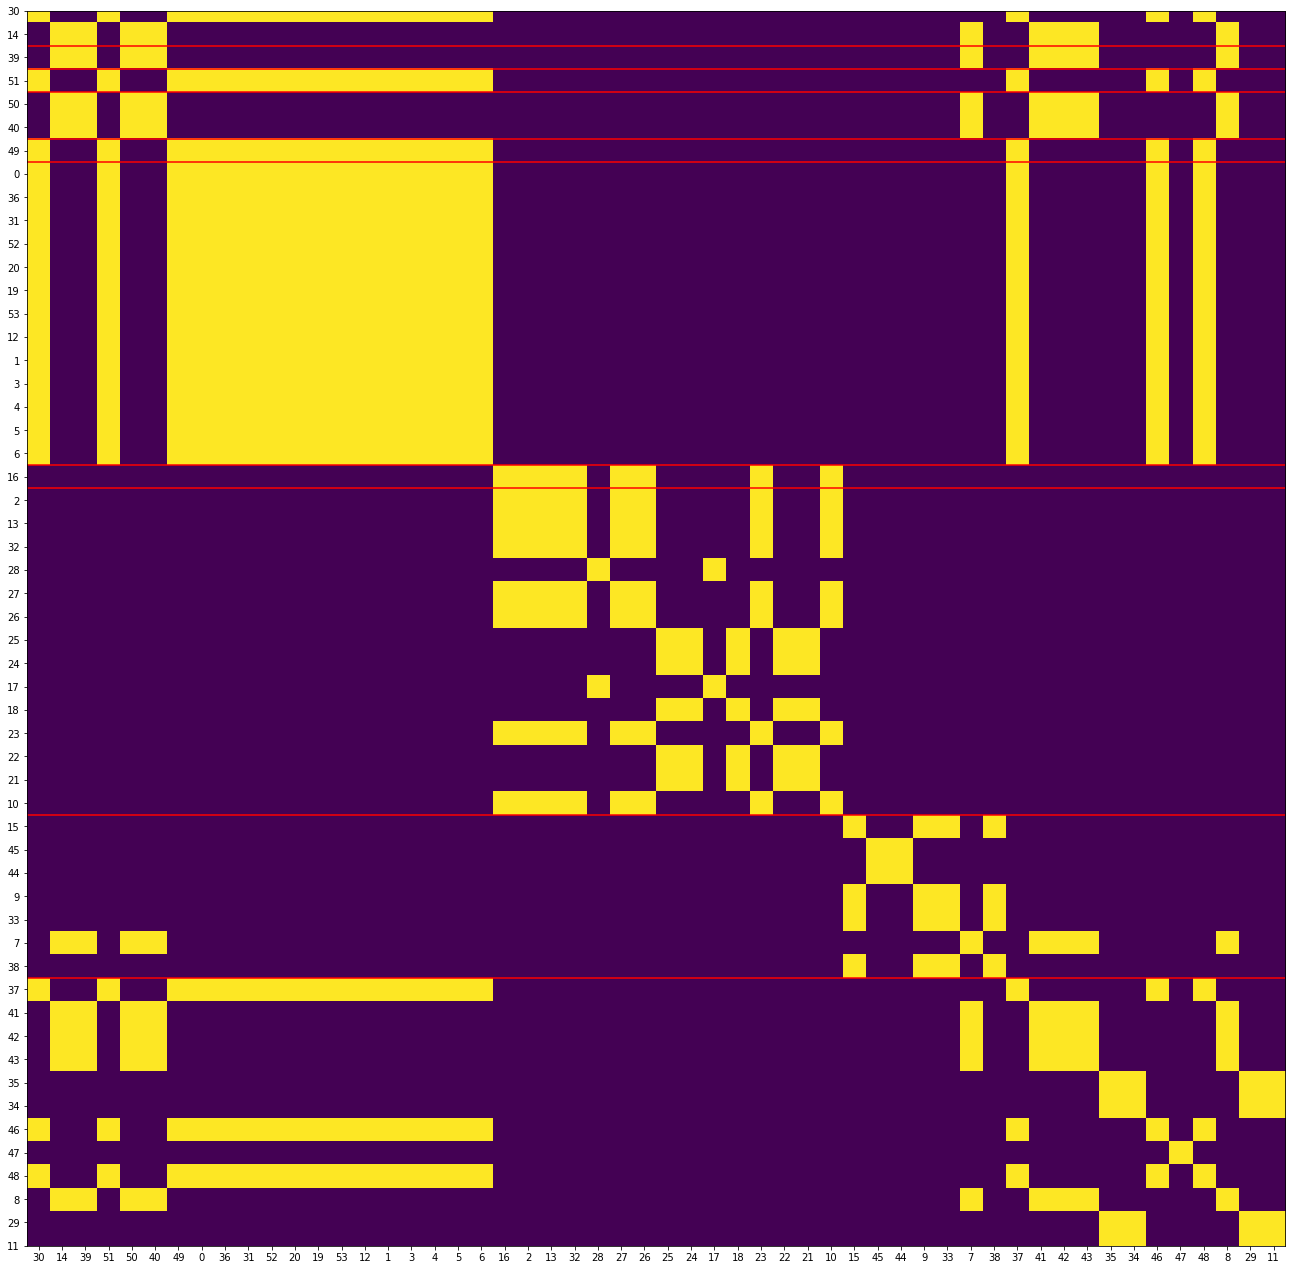

572.0

In [11]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "model"]
table = "experiments_solution"
print(get_where_items(exp_id, cols, table)[0])
_, clusters1, _ = assign_to_cluster(exp_id, cols, table, solutions, solutions)

exp_id = 29310
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
get_where_items(exp_id, cols, table)
print(get_where_items(exp_id, cols, table)[0])
_, clusters2, _ = assign_to_cluster(exp_id, cols, table, solutions, solutions)

heatmap = get_cluster_sets(clusters1, clusters2)
heatmap.sum()

('CountVectorizer', 0.05, True, <memory at 0x7f462aca7348>, [1, 3])
('CountVectorizer', 0.05, True, <memory at 0x7f462aca7348>, [1, 3])
[3, 3, 3, 8, 5, 8, 5, 5, 8, 8, 3, 10, 4, 11, 1, 11, 3, 3, 4, 5, 3, 3, 11, 0, 0, 10, 11, 11, 5, 5, 5, 10, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 9, 1, 10, 1]


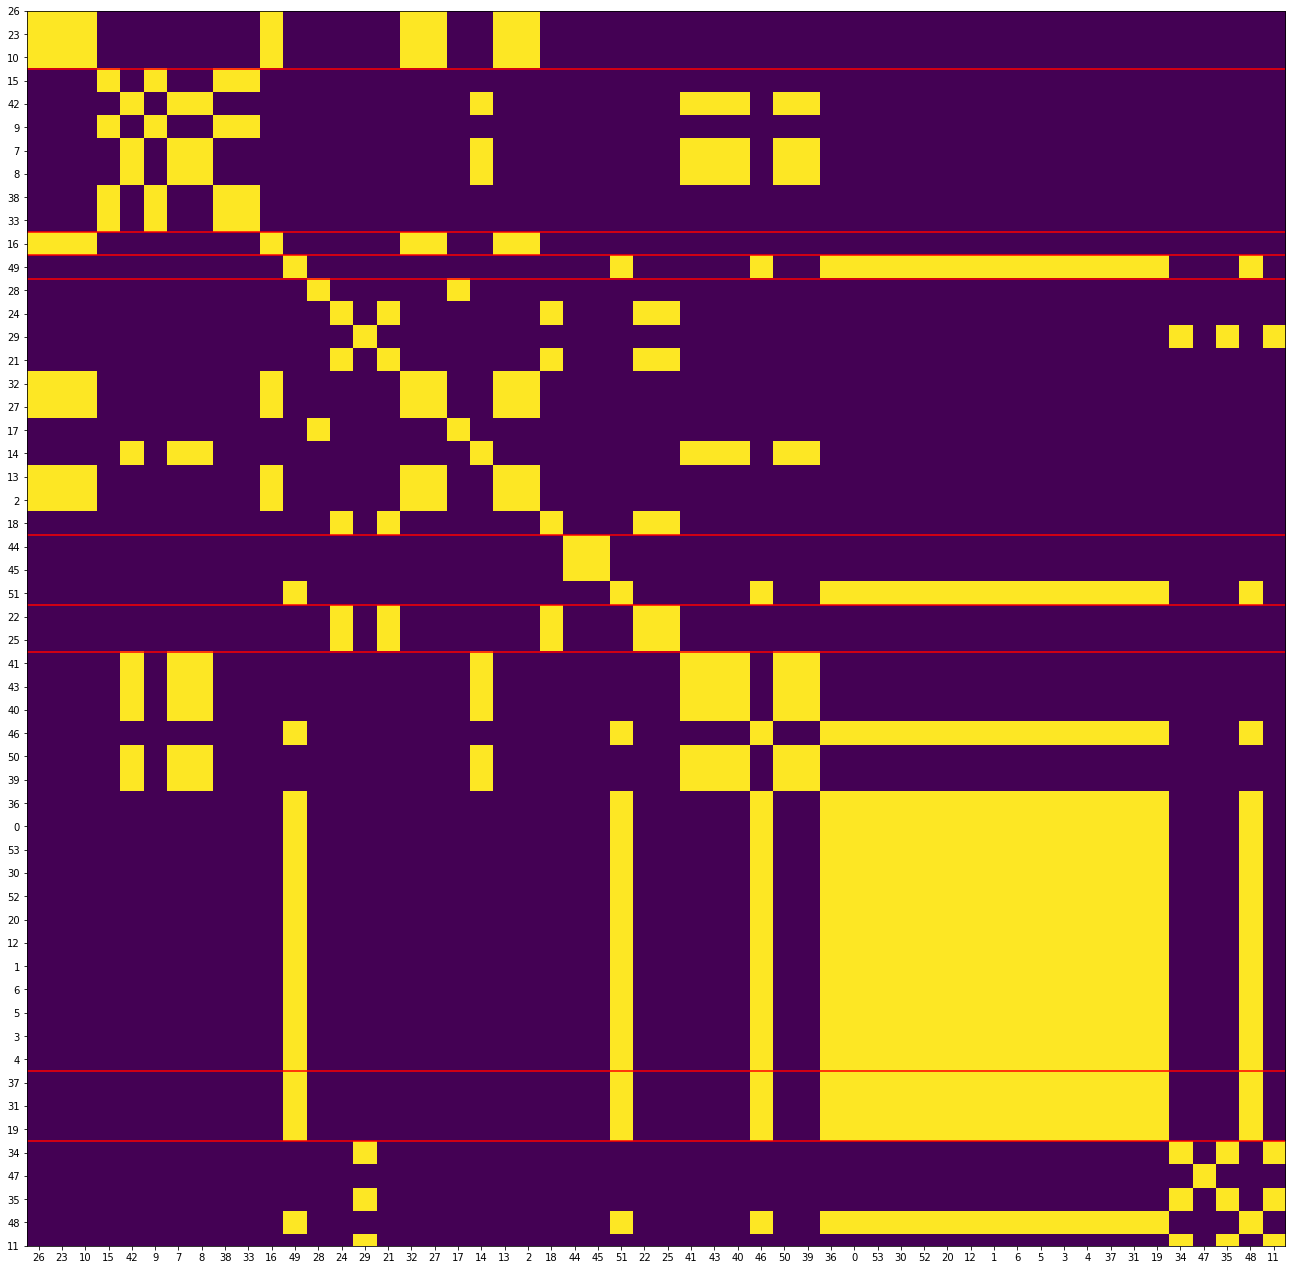

572.0

In [12]:
exp_id = 78030
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
get_where_items(exp_id, cols, table)
print(get_where_items(exp_id, cols, table)[0])
_, clusters1, _ = assign_to_cluster(exp_id, cols, table, solutions, solutions)

exp_id = 29310
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
get_where_items(exp_id, cols, table)
print(get_where_items(exp_id, cols, table)[0])
_, clusters2, _ = assign_to_cluster(exp_id, cols, table, solutions, solutions)

heatmap = get_cluster_sets(clusters1, clusters2)
heatmap.sum()

In [5]:
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))
len(new_solutions)

65

### Calculate PMI (UCI Coherence) - just docs from cluster

In [55]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "model"]
table = "experiments_solution"
where_items = get_where_items(exp_id, cols, table)
model_db = pickle.loads(base64.b64decode(where_items[0][3]))

# Get train solutions clusters
vectorizer, clusters_train, train_data_features = assign_to_cluster(exp_id, cols, table, solutions, solutions)

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

# Get test solutions clusters
vectorizer, clusters, test_data_features = assign_to_cluster(exp_id, cols, table, solutions, new_solutions)
# Adjust clusters
clusters[30] = 5
clusters[20] = 5
clusters[29] = 5

k_pmi5 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
k_pmi10 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
k_pmi15 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 PMI coherence: %.2f" % k_pmi5[1])
print("Top-10 PMI coherence: %.2f" % k_pmi10[1])
print("Top-15 PMI coherence: %.2f" % k_pmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Top-5 PMI coherence: -2.21
Top-10 PMI coherence: -2.24
Top-15 PMI coherence: -2.23
Top-5 NPMI coherence: 0.85
Top-10 NPMI coherence: 0.93
Top-15 NPMI coherence: 0.90
Top-5 NPMI coherence (train): 0.98
Top-10 NPMI coherence (train): 0.97
Top-15 NPMI coherence (train): 0.96
Top-5 NPMI coherence: 0.71
Top-10 NPMI coherence: 0.79
Top-15 NPMI coherence: 0.77
Top-5 NPMI coherence (train): 0.74
Top-10 NPMI coherence (train): 0.75
Top-15 NPMI coherence (train): 0.74


In [24]:
from itertools import permutations, combinations
import numpy as np

def calculate_uci_npmi_coherence_all_docs(X, word_topic, clusters, k, N=5):
    """ Calculates NPMI for the top-N words using an external dataset.  """
    k_pmi = []
    count_data = X.copy()
    # Transform to binary count
    count_data[np.where(count_data != 0)] = 1

    # For each cluster, calculate PMI
    for idx_cluster in range(0, k):

        cluster_data = count_data[clusters == idx_cluster]

        # If there aren't any documents assigned to the cluster, skip it
        if cluster_data.shape[0] == 0:
            continue

        # Calculate cooccurence matrix
        cooccurence = np.dot(count_data.T, count_data)

        # For each topic, get N top words
        idx = word_topic[:,idx_cluster].argsort()[::-1][:N]
        total = cooccurence[idx,:][:,idx].diagonal().sum()
        combs = combinations(idx, 2)
        k_score = []
        for i,j in combs:
            if cooccurence[i,i] == 0 or cooccurence[j,j] == 0:
#                 continue
                print(np.where(clusters == idx_cluster))
                print(cooccurence[idx,:][:,idx])
                raise RuntimeError("Some words do not occur in topic %d. Choose a smaller number of N." %
                                   idx_cluster)
            p_i = cooccurence[i,i]/total
            p_j = cooccurence[j,j]/total
            p_i_j = cooccurence[i,j]/total
            score = np.log((p_i_j+0.001)/(p_i * p_j))/-np.log(p_i_j+0.001)
            k_score.append(score)
        k_topic = np.mean(np.asarray(k_score))
        k_pmi.append(k_topic)
    return k_pmi, np.mean(k_pmi), np.std(k_pmi)

In [51]:
from itertools import permutations, combinations
import numpy as np

def calculate_uci_npmi_coherence(X, word_topic, clusters, k, N=5):
    """ Calculates NPMI for the top-N words using an external dataset.  """
    k_pmi = []
    count_data = X.copy()
    # Transform to binary count
    count_data[np.where(count_data != 0)] = 1

    # For each cluster, calculate PMI
    for idx_cluster in range(0, k):

        cluster_data = count_data[clusters == idx_cluster]

        # If there aren't any documents assigned to the cluster, skip it
        if cluster_data.shape[0] == 0:
            continue

        # Calculate cooccurence matrix
        cooccurence = np.dot(cluster_data.T, cluster_data)

        # For each topic, get N top words
        idx = word_topic[:,idx_cluster].argsort()[::-1][:N]
        total = cooccurence[idx,:][:,idx].diagonal().sum()
        combs = combinations(idx, 2)
        k_score = []
        for i,j in combs:
            if cooccurence[i,i] == 0 or cooccurence[j,j] == 0:
                print(np.where(clusters == idx_cluster))
                print(cooccurence[idx,:][:,idx])
                raise RuntimeError("Some words do not occur in topic %d. Choose a smaller number of N." %
                                   idx_cluster)
            p_i = cooccurence[i,i]/total
            p_j = cooccurence[j,j]/total
            p_i_j = cooccurence[i,j]/total
            score = np.log((p_i_j+0.001)/(p_i * p_j))/-np.log(p_i_j+0.001)
            k_score.append(score)
        k_topic = np.mean(np.asarray(k_score))
        k_pmi.append(k_topic)
    return k_pmi, np.mean(k_pmi), np.std(k_pmi)

In [28]:
exp_id = 79
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
where_items = get_where_items(exp_id, cols, table)
model_db = pickle.loads(base64.b64decode(where_items[0][3]))

# Get train solutions clusters
vectorizer, clusters_train, train_data_features = assign_to_cluster(exp_id, cols, table, solutions, solutions)

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

# Get test solutions clusters
vectorizer, clusters, test_data_features = assign_to_cluster(exp_id, cols, table, solutions, new_solutions)
clusters[61] = -1
clusters[20] = 0
clusters[41] = 0

k_pmi5 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
# k_pmi10 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
# k_pmi15 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 PMI coherence: %.2f" % k_pmi5[1])
# print("Top-10 PMI coherence: %.2f" % k_pmi10[1])
# print("Top-15 PMI coherence: %.2f" % k_pmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
# k_npmi10 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
# k_npmi15 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
# print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
# print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 5)
# k_npmi10 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 10)
# k_npmi15 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
# print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
# print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 5)
# k_npmi10 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 10)
# k_npmi15 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
# print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
# print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 5)
# k_npmi10 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 10)
# k_npmi15 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
# print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
# print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

Top-5 PMI coherence: -1.56
Top-5 NPMI coherence: 0.92
Top-5 NPMI coherence (train): 0.98
Top-5 NPMI coherence: 0.74
Top-5 NPMI coherence (train): 0.75


In [52]:
exp_id = 78030
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
where_items = get_where_items(exp_id, cols, table)
model_db = pickle.loads(base64.b64decode(where_items[0][3]))

# Get train solutions clusters
vectorizer, clusters_train, train_data_features = assign_to_cluster(exp_id, cols, table, solutions, solutions)

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

# Get test solutions clusters
vectorizer, clusters, test_data_features = assign_to_cluster(exp_id, cols, table, solutions, new_solutions)

k_pmi5 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
k_pmi10 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
k_pmi15 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 PMI coherence: %.2f" % k_pmi5[1])
print("Top-10 PMI coherence: %.2f" % k_pmi10[1])
print("Top-15 PMI coherence: %.2f" % k_pmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

Top-5 PMI coherence: -2.32
Top-10 PMI coherence: -2.36
Top-15 PMI coherence: -2.40
Top-5 NPMI coherence: 0.98
Top-10 NPMI coherence: 0.94
Top-15 NPMI coherence: 0.89
Top-5 NPMI coherence (train): 1.01
Top-10 NPMI coherence (train): 0.99
Top-15 NPMI coherence (train): 0.97
Top-5 NPMI coherence: 0.85
Top-10 NPMI coherence: 0.81
Top-15 NPMI coherence: 0.76
Top-5 NPMI coherence (train): 0.79
Top-10 NPMI coherence (train): 0.75
Top-15 NPMI coherence (train): 0.75


In [30]:
exp_id = 29310
cols = ["vectorizer", "min_df", "is_binary", "model", "ngrams"]
table = "experiments_2020_01_27"
where_items = get_where_items(exp_id, cols, table)
model_db = pickle.loads(base64.b64decode(where_items[0][3]))

# Get train solutions clusters
vectorizer, clusters_train, train_data_features = assign_to_cluster(exp_id, cols, table, solutions, solutions)

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

# Get test solutions clusters
vectorizer, clusters, test_data_features = assign_to_cluster(exp_id, cols, table, solutions, new_solutions)
clusters[20] = 10

k_pmi5 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
k_pmi10 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
k_pmi15 = calculate_uci_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 PMI coherence: %.2f" % k_pmi5[1])
print("Top-10 PMI coherence: %.2f" % k_pmi10[1])
print("Top-15 PMI coherence: %.2f" % k_pmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence_all_docs(test_data_features, model_db.components_.T, clusters, 12, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 10)
k_npmi15 = calculate_uci_npmi_coherence_all_docs(train_data_features, model_db.components_.T, clusters_train, 12, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

Top-5 PMI coherence: -2.10
Top-10 PMI coherence: -2.12
Top-15 PMI coherence: -2.13
Top-5 NPMI coherence: 0.87
Top-10 NPMI coherence: 0.93
Top-15 NPMI coherence: 0.90
Top-5 NPMI coherence (train): 0.99
Top-10 NPMI coherence (train): 0.99
Top-15 NPMI coherence (train): 0.97
Top-5 NPMI coherence: 0.65
Top-10 NPMI coherence: 0.77
Top-15 NPMI coherence: 0.76
Top-5 NPMI coherence (train): 0.66
Top-10 NPMI coherence (train): 0.76
Top-15 NPMI coherence (train): 0.76


In [57]:
exp_id = 26
cols = ["vectorizer", "min_df", "is_binary", "model"]
table = "experiments_solution"
where_items = get_where_items(exp_id, cols, table)
# model_db = pickle.loads(base64.b64decode(where_items[0][3]))

# Get train solutions clusters
vectorizer, _, train_data_features = assign_to_cluster(exp_id, cols, table, solutions, solutions)
model = KMeans(n_clusters=5, random_state=0)
clusters_train = model.fit_predict(train_data_features)
clf = LogisticRegression(random_state=0, multi_class='ovr').fit(train_data_features, clusters_train)
word_topic = clf.coef_.T

# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

# Get test solutions clusters
vectorizer, _, test_data_features = assign_to_cluster(exp_id, cols, table, solutions, new_solutions)
clusters = model.predict(test_data_features)
# # Adjust clusters
# clusters[42] = -1
# clusters[30] = 5
# clusters[20] = 5
# clusters[29] = 5

k_pmi5 = calculate_uci_coherence(test_data_features, word_topic, clusters, 5, 5)
k_pmi10 = calculate_uci_coherence(test_data_features, word_topic, clusters, 5, 10)
# k_pmi15 = calculate_uci_coherence(test_data_features, word_topic, clusters, 5, 15)

print("Top-5 PMI coherence: %.2f" % k_pmi5[1])
print("Top-10 PMI coherence: %.2f" % k_pmi10[1])
# print("Top-15 PMI coherence: %.2f" % k_pmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(test_data_features, word_topic, clusters, 5, 5)
k_npmi10 = calculate_uci_npmi_coherence(test_data_features, word_topic, clusters, 5, 10)
# k_npmi15 = calculate_uci_npmi_coherence(test_data_features, word_topic, clusters, 5, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
# print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence(train_data_features, word_topic, clusters_train, 5, 5)
k_npmi10 = calculate_uci_npmi_coherence(train_data_features, word_topic, clusters_train, 5, 10)
k_npmi15 = calculate_uci_npmi_coherence(train_data_features, word_topic, clusters_train, 5, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, clusters, 5, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, clusters, 5, 10)
# k_npmi15 = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, clusters, 5, 15)

print("Top-5 NPMI coherence: %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence: %.2f" % k_npmi10[1])
# print("Top-15 NPMI coherence: %.2f" % k_npmi15[1])

k_npmi5 = calculate_uci_npmi_coherence_all_docs(train_data_features, word_topic, clusters_train, 5, 5)
k_npmi10 = calculate_uci_npmi_coherence_all_docs(train_data_features, word_topic, clusters_train, 5, 10)
k_npmi15 = calculate_uci_npmi_coherence_all_docs(train_data_features, word_topic, clusters_train, 5, 15)

print("Top-5 NPMI coherence (train): %.2f" % k_npmi5[1])
print("Top-10 NPMI coherence (train): %.2f" % k_npmi10[1])
print("Top-15 NPMI coherence (train): %.2f" % k_npmi15[1])

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Top-5 PMI coherence: -2.38
Top-10 PMI coherence: -2.59
Top-5 NPMI coherence: 0.78
Top-10 NPMI coherence: 0.69
Top-5 NPMI coherence (train): 0.87
Top-10 NPMI coherence (train): 0.83
Top-15 NPMI coherence (train): 0.80
Top-5 NPMI coherence: 0.72
Top-10 NPMI coherence: 0.53
Top-5 NPMI coherence (train): 0.76
Top-10 NPMI coherence (train): 0.66
Top-15 NPMI coherence (train): 0.68
